In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.fft import rfft, rfftfreq, fft
from scipy.stats import entropy

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [8]:
df = pd.read_csv("entropy_example_data.csv.gz", parse_dates=["timestamp"])
df["date"] = df.timestamp.dt.date
df["mag"] = np.sqrt(df.x**2 + df.y**2 + df.z**2)

In [9]:
def fft_getter(df, t):
    
    if(len(df) >  t):
        
        df = df.head(t)
        
        signal1 = df.mag.to_numpy()

        yf1 = rfft(signal1) 
        yf1 = np.abs(yf1)
        
        diff = 1 / 25.
        freq = np.fft.rfftfreq(signal1.size, d=diff)

        idx = np.argsort(freq)

        return yf1[idx], freq[idx]
    
    return None

def stats_getter(spect, freqs, T):
    T2 = (T/ 25)**2
    M = 70

    # Power
    MpiT = (M / ((2*np.pi)*T2))
    power = MpiT * ((spect**2).sum(axis=1))

    # Mean
    mean = np.average(spect, weights=freqs, axis=1)

    # Var
    std = np.average(spect**2 - mean[:,None]**2, weights=freqs**2, axis=1)

    # Entropy
    piTM = (((2*np.pi)*T2)/M)
    rho = piTM * (spect**2) / (power[:,None])
    #entr = ((rho * np.log(rho)).sum(axis=1)) * -1
    entr = entropy(rho, axis=1)

    return mean, std, entr, power

def get_analysis(df):
    lens = []
    df.groupby("date").apply(lambda x : lens.append(len(x)))
    T = int(np.round(np.mean(lens)+(0.3*np.std(lens))))
    #T = 10_000
    dates = []
    spect = []
    freqs = []

    for date, el in df.groupby("date"):
        res = fft_getter(el, T)
        if(res != None):
            spect.append(res[0])
            freqs.append(res[1])
            dates.append(date)

    spect = np.vstack(spect)
    freqs = np.vstack(freqs)

    mean, std, entr, power = stats_getter(spect, freqs, T)

    analysis = pd.DataFrame({"date": pd.to_datetime(dates),
                             "mean": mean.tolist(), 
                             "std": std.tolist(), 
                             "entropy": entr.tolist(), 
                             "pow": power.tolist()})

    analysis["month"] = analysis.date.dt.month.astype(str)
    analysis["week"] = analysis.date.dt.isocalendar().week.astype(str)
    
    return analysis

In [10]:
analysis = get_analysis(df)
analysis.head()

,date,mean,std,entropy,pow,month,week
0,2022-08-01,4.329416,11.621306,0.154460,7314.779487,8,31
1,2022-08-05,4.311858,11.227333,0.155798,7324.213554,8,31
2,2022-08-10,5.014158,6.971983,0.147217,7328.511794,8,32
3,2022-08-11,4.691058,11.538018,0.165106,7329.824859,8,32
4,2022-08-12,5.398525,6.580159,0.151259,7355.186150,8,32


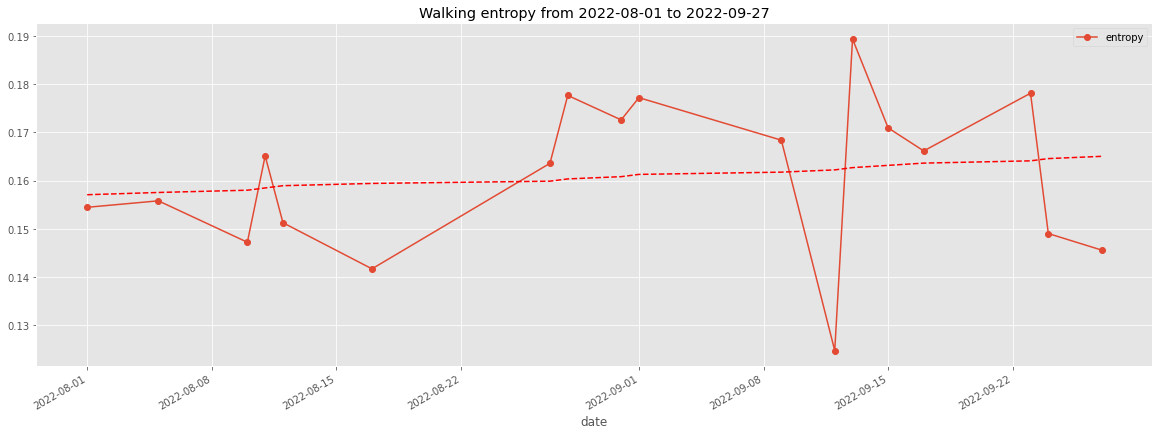

In [21]:
z = np.polyfit(np.arange(len(analysis)), analysis.entropy, 1)
p = np.poly1d(z)
analysis.plot(x="date", y="entropy", kind="line", figsize=(20, 7), marker="o", title=f"Walking entropy from {analysis.date.min().date()} to {analysis.date.max().date()}")
plt.plot(analysis.date, p(np.arange(len(analysis))), "r--")